# Análise exploratória de dados

## Carregar bibliotecas

In [1]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import nltk


nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('portuguese')
sns.set_palette("colorblind")

[nltk_data] Downloading package stopwords to /home/amanda/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dicionário de dados

In [2]:
pd.read_csv('../data/external/dicionario.csv')

,variavel,significado,tipo,Unnamed: 3
0,id,ID único por usuário,nominal,NaN
1,tweet_text,Texto publicado,nominal,NaN
2,tweet_date,Data de publicação,nominal,NaN
3,sentiment,Algorítmo de classificação do sentimento do us...,nominal,"[0,1,2]"
4,query_used,Palavra relevante,nominal,"[':)', ':(', 'veja', 'jornaloglobo', 'g1', 'fo..."


## Leitura do arquivo de dados

In [3]:
db = pd.read_csv('../data/raw/data.csv', delimiter=";")
db.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


## 1. Descrição dos dados

In [5]:
# Quantidade de linhas x colunas
db.shape

(100000, 5)

A base de dados possui $1 \times 10^5$ instâncias e cinco colunas, das quais 3 correspondem a variáveis discretas e duas a variáveis qualitativas.

In [6]:
# Nome das colunas que representam as variáveis
db.columns

Index(['id', 'tweet_text', 'tweet_date', 'sentiment', 'query_used'], dtype='object')

In [7]:
#Tipo e contagem por coluna
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   tweet_text  100000 non-null  object
 2   tweet_date  100000 non-null  object
 3   sentiment   100000 non-null  int64 
 4   query_used  100000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.8+ MB


In [8]:
# Número de valores nulos
db.isnull().sum()

id            0
tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

A base de dados não possui valores nulos. 

## 1.1. Obtenção dos períodos do dia

In [9]:
db['date'] = pd.to_datetime(db['tweet_date'])
db['period'] = (db['date'].dt.hour % 24 + 4) // 4
db['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)
db['sentiment'].replace({0: 'Negative',
                         1: 'Positive',
                         2: 'Neutral'}, inplace=True)
db.head()

,id,tweet_text,tweet_date,sentiment,query_used,date,period
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,Positive,:),2018-10-12 16:29:25+00:00,Evening
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,Positive,:),2018-10-12 16:29:04+00:00,Evening
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,Positive,:),2018-10-12 16:28:56+00:00,Evening
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,Positive,:),2018-10-12 16:28:49+00:00,Evening
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,Positive,:),2018-10-12 16:28:49+00:00,Evening


## 1.2. Quantidade de tweets por período

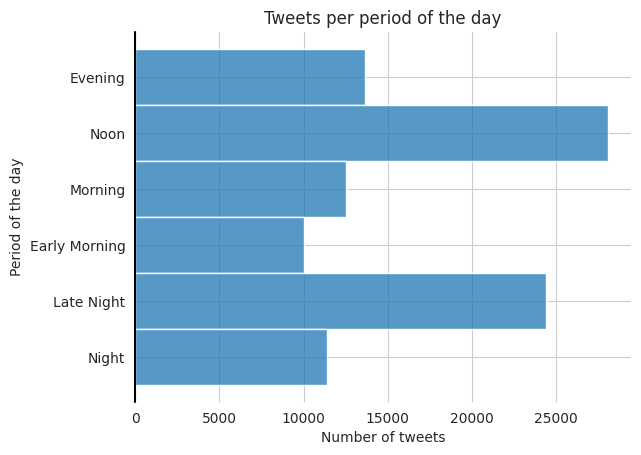

In [10]:
sns.set_style('whitegrid')
axis = sns.histplot(data=db, y='period')
axis.set(frame_on=False)
axis.axvline(0, color='k', clip_on=False)
plt.ylabel('Period of the day')
plt.xlabel('Number of tweets')
plt.title('Tweets per period of the day')
plt.show()

Baseado no gráfico, a maior parte dos tweets concentram-se no período da tarde e madrugada. Veremos agora a relação entre os tweets positivos, negativos e neutros durante o período a partir do gráfico a seguir:

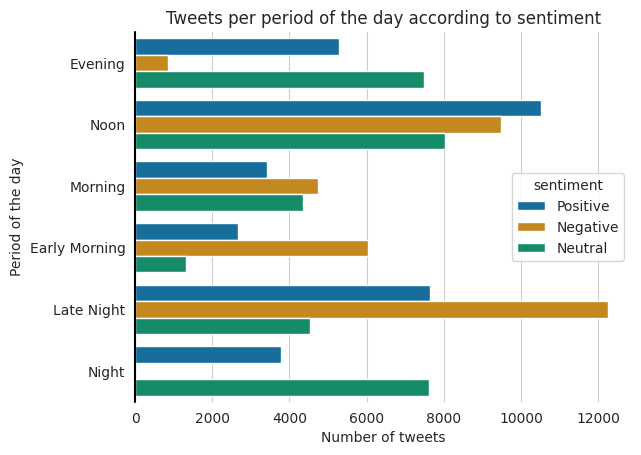

In [23]:
sns.set_style('whitegrid')
axis = sns.countplot(data=db, y='period', hue='sentiment',)
                   #palette={'Negative': 'red', 'Neutral': 'gray' , 'Positive': 'green'})
axis.set(frame_on=False)
axis.axvline(0, color='k', clip_on=False)
plt.ylabel('Period of the day')
plt.xlabel('Number of tweets')
plt.title('Tweets per period of the day according to sentiment')
plt.show()

Observa-se que durante a madrugada a maioria dos tweets tendem a ser negativos. No meio-dia os positivos estão ligeiramente à frente dos negativos e durante o período noturno tweets negativos são inexistentes, sendo em sua maioria neutros.

## 1.3. Palavras mais frequentes

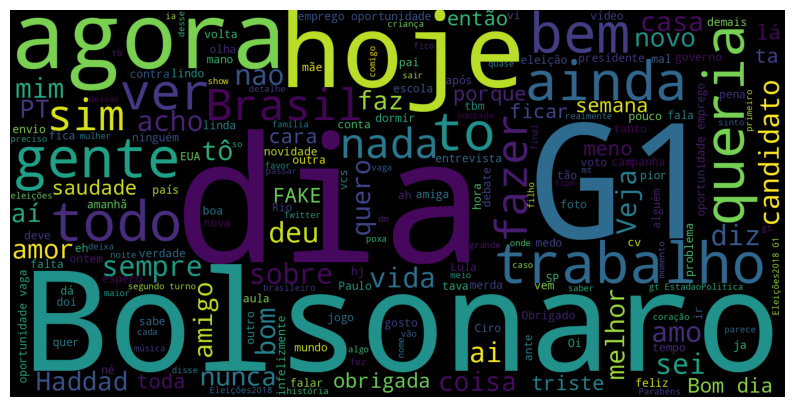

In [31]:
tweet_text = db.dropna(subset=['tweet_text'], axis=0)['tweet_text'] # eliminar as colunas com valores que não vão ser analisados
tweet_text.head()

# Concatena as palavras
tweets = " ".join(s for s in tweet_text)

# Lista de stopword
stopwords = set(STOPWORDS)
stopwords.update(["a","b","c","d","fato","ela","estou","nem","tudo","p","pq","quando","dele","RT","por","de",'dar','pois','em','um','da','ser','aqui','vou','dos','ter','não','ao','sou','seu','à','n','se','esse','uma','mais','ele','fazendo','você','pode','essa','é','mas','segue','pra','isso','vez','para','muito','pelo','pela','são', 'na','vamos','https','t','co','c','New','eu','seis','retweets','ano','pessoa','likes','vai','que','ou','anos','7dias','tirou','tem','q','0','O','e','os','assim','só','mesmo','tá','pro','votar','pessoas','vc'])

# Gera uma wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(tweets)

# Mostra a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

## 2. Perguntas de partida e hipóteses

Com base na análise dos dados referentes a classificação de sentimentos do twitter, surgem as seguintes perguntas:
   1. Por que alguns períodos do dia possuem mais tweets do que outros?
   
   2. Qual a correlação entre o tipo de sentimento do usuário e o período do dia?
   
   3. O conteúdo do tweet é relevante para a avaliação do sentimento?
    
Como hipóteses temos:
  1. A disponibilidade das pessoas para realizar tweets varia conforme o tempo livre. No final da tarde, que para a grande maioria corresponde ao fim do expediente de trabalho/estudantil, os usuários possuem maior tempo para usufruirem das mídias socias. Assim como também no final da noite que pode ser um horário mais confortável para escrever sem se preocupar com afazeres posteriores.
  
  2. Ao acordar, muitas pessoas estão com pouca disposição e precisam lidar com a expectativa de iniciar algum tipo de trabalho ou atividade análoga, causando uma maioria de sentimentos negativos e neutros. Durante a tarde, metade do dia se foi e os sentimentos positivos aumentam e pela noite tendem a desaparecer devido ao encerramento das atividades. Já na madrugada, vemos uma maioria esmagadora de sentimentos negativos tendo em vista que uma parcela minoritária da população se encontra acordada nesse horário e muito provavelmente devem sofrer de insônia e doenças relacionadas que podem causar sentimentos negativos.
  
  3. O conteúdo pode não ter muita relação, mas a palavra-chave utilizada pelo banco de dados nos mostra uma tendência sentimental em relação ao conteúdo dos tweets que a utilizam.

## 3. Insights

Como observado nos gráficos, nos períodos de fim de tarde e noturno os sentimentos negativos dos usuários do twitter diminuem progressivamente até praticamente inexistirem após altas horas da noite.

Esses dados podem ser úteis para detectar que tipos de usuários podem estar sofrendo com insônia e estresse. É possível notar, a partir dessa análise, não somente informações do dia-a-dia dos usuários, mas também extrair informações valiosas a respeito do seu perfil e direcionar conteúdos de propaganda que sejam relevantes naquele momento do seu dia.